In [182]:
import os
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
from tqdm import tqdm

from sklearn.decomposition import PCA

In [183]:
if not os.path.basename(os.getcwd()) == 'Seismic-Multilabel-Event-Classifier':
    os.chdir('..')
    print(f"Changed directory to {os.getcwd()}")

In [184]:
# Dataset path
DATA_PATH = 'data/interim/datosML.json'  
df_raw = pd.read_json(DATA_PATH, lines=True)
print('Loaded', df_raw.shape[0], 'rows')
df_raw.head()

Loaded 1696 rows


,Archivo,NPTS,Falla,Mag,Vs,Time,AccV,AccH2,AccH1
0,RSN8478_PARK2004,32169,1 Stiker Slip (SS),4-6,600-,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[3.34e-08, 3.3700000000000004e-08, 3.39e-08, 3...","[-5.5800000000000003e-08, -5.65e-08, -5.730000...","[-1.93e-08, -1.93e-08, -1.93e-08, -1.93e-08, -..."
1,RSN8700_40204628,20001,1 Stiker Slip (SS),4-6,600-,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[8.5e-09, 8.9e-09, 9.2e-09, 9.5e-09, 9.7000000...","[-2.2000000000000003e-09, -2.3e-09, -2.4e-09, ...","[8e-10, 1.2e-09, 1.6e-09, 2e-09, 2.4e-09, 2.80..."
2,RSN8459_PARK2004,32380,1 Stiker Slip (SS),4-6,600-,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[5.86e-08, 5.94e-08, 6.02e-08, 6.1e-08, 6.17e-...","[2.7200000000000002e-08, 2.7e-08, 2.6800000000...","[1.5000000000000002e-08, 1.4900000000000001e-0..."
3,RSN2148_BEARCTY,8200,1 Stiker Slip (SS),4-6,600-,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[-2.27684e-05, -2.11897e-05, -2.81075e-05, 1.7...","[7.438800000000001e-06, 5.522000000000001e-06,...","[1.0019400000000001e-05, 9.6351e-06, 1.25398e-..."
4,RSN8426_BEARCTY,14465,1 Stiker Slip (SS),4-6,600-,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[3.1e-09, 3.1e-09, 3.1e-09, 3.1e-09, 3.1e-09, ...","[4e-10, 4e-10, 4e-10, 4e-10, 4e-10, 4e-10, 4e-...","[2.9e-09, 2.9e-09, 2.9e-09, 2.9e-09, 2.8000000..."


In [185]:
# Ensure signals are flat NumPy arrays
for col in ['AccV','AccH1','AccH2']:
    df_raw[col] = df_raw[col].apply(lambda x: np.array(x).flatten())

In [186]:
def extract_time_features(sig: np.ndarray, dt: float, prefix: str):
    """Compute max, rms of a signal"""
    feats = {
        f'max_{prefix}': np.max(sig),
        f'rms_{prefix}': np.sqrt(np.mean(sig**2)),
    }
    return feats

def zero_crossing_rate(sig: np.ndarray, dt: float):
    crossings = np.where(np.diff(np.signbit(sig)))[0]
    duration = len(sig) * dt
    return len(crossings) / duration if duration > 0 else 0.0

def fft_features(sig: np.ndarray, dt: float, prefix: str, n_fft: int = 512, band_split: float = 5.0):
    """Return dict with FFT magnitude vector and summary stats"""
    mag = np.abs(fft(sig, n=n_fft))[:n_fft//2 + 1]  # unilateral spectrum
    freqs = fftfreq(n_fft, d=dt)[:n_fft//2 + 1]
    dom_freq = freqs[np.argmax(mag)]
    centroid = (freqs * mag).sum() / (mag.sum() + 1e-12)
    bandwidth = np.sqrt(((freqs - centroid)**2 * mag).sum() / (mag.sum() + 1e-12))
    low_energy = mag[freqs < band_split].sum()
    high_energy = mag[freqs >= band_split].sum()
    spec_ratio = high_energy / (low_energy + 1e-12)
    feats = {
        f'dom_freq_{prefix}': dom_freq,
        f'centroid_{prefix}': centroid,
        f'bandwidth_{prefix}': bandwidth,
        f'spec_ratio_{prefix}': spec_ratio,
        f'FFTmag_{prefix}': mag  # store vector; will flatten later
    }
    return feats

In [187]:
feature_rows = []
n_fft = 512
for idx, row in tqdm(df_raw.iterrows(), total=df_raw.shape[0]):
    dt = row['DT'] if 'DT' in row else 0.01
    feats = {}

    # time‑domain stats
    for comp in ['V','H1','H2']:
        sig = row[f'Acc{comp}']
        feats.update(extract_time_features(sig, dt, comp))
    # duration
    feats['duration'] = (len(row['AccV']) - 1) * dt
    # zero‑crossing rate of vertical
    feats['zcr_V'] = zero_crossing_rate(row['AccV'], dt)

    # FFT based
    for comp in ['V','H1','H2']:
        feats.update(fft_features(row[f'Acc{comp}'], dt, comp, n_fft=n_fft))

    feature_rows.append(feats)

features_df = pd.DataFrame(feature_rows, index=df_raw.index)
print('Created feature matrix shape:', features_df.shape)

100%|██████████| 1696/1696 [00:00<00:00, 5204.02it/s]

Created feature matrix shape: (1696, 23)


In [188]:

# Aplanar FFT mags
fft_dfs = []
for comp in ['V','H1','H2']:
    arr = np.vstack(features_df[f'FFTmag_{comp}'].values)
    cols = [f'FFTmag_{comp}_{i}' for i in range(arr.shape[1])]
    fft_dfs.append(pd.DataFrame(arr, columns=cols, index=features_df.index))
flat_fft = pd.concat(fft_dfs, axis=1)
# Limpiar y unir
features_df = features_df.drop(columns=[f'FFTmag_{c}' for c in ['V','H1','H2']])
features_df = pd.concat([features_df, flat_fft], axis=1)
print('Feature matrix shape before PCA:', features_df.shape)


Feature matrix shape before PCA: (1696, 791)


In [189]:

# Aplicar PCA para 95% varianza
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
fft_cols = [c for c in features_df.columns if c.startswith('FFTmag_')]
other_cols = [c for c in features_df.columns if not c.startswith('FFTmag_')]
fft_data = features_df[fft_cols]
pca_transformed = pca.fit_transform(fft_data)
pca_cols = [f'FFT_PCA_{i+1}' for i in range(pca_transformed.shape[1])]
df_pca = pd.DataFrame(pca_transformed, columns=pca_cols, index=features_df.index)
print('PCA components:', len(pca_cols))


PCA components: 62


In [190]:

# Dataset final con PCA
df_features = pd.concat([features_df[other_cols], df_pca], axis=1)
print('Final feature shape:', df_features.shape)
df_features.head()


Final feature shape: (1696, 82)


,max_V,rms_V,max_H1,rms_H1,max_H2,rms_H2,duration,zcr_V,dom_freq_V,centroid_V,...,FFT_PCA_53,FFT_PCA_54,FFT_PCA_55,FFT_PCA_56,FFT_PCA_57,FFT_PCA_58,FFT_PCA_59,FFT_PCA_60,FFT_PCA_61,FFT_PCA_62
0,0.000342,0.000052,0.000587,0.000111,0.000617,0.000107,321.68,2.014362,0.000000,5.447156,...,-0.010389,0.015152,-0.001620,-0.007796,-0.002894,0.008734,0.005754,-0.005610,0.001254,0.015319
1,0.003967,0.000347,0.006399,0.000501,0.004988,0.000475,200.00,9.034548,0.781250,17.551070,...,-0.010391,0.015147,-0.001616,-0.007771,-0.002902,0.008747,0.005756,-0.005632,0.001243,0.015314
2,0.000135,0.000023,0.000204,0.000028,0.000157,0.000026,323.79,1.429895,0.195312,2.573894,...,-0.010390,0.015150,-0.001616,-0.007797,-0.002894,0.008739,0.005757,-0.005620,0.001256,0.015312
3,0.003166,0.000453,0.005030,0.000657,0.004669,0.000725,41.00,21.189954,14.062500,14.019404,...,-0.049580,0.007665,-0.000685,-0.019198,0.014396,-0.024908,0.009837,0.006000,0.004093,0.001835
4,0.000011,0.000002,0.000021,0.000003,0.000018,0.000003,180.80,3.943366,0.195312,10.936094,...,-0.010387,0.015149,-0.001617,-0.007796,-0.002892,0.008732,0.005761,-0.005615,0.001260,0.015316


In [191]:

# Unir etiquetas originales
df_final = pd.concat([df_raw[['Archivo','Falla','Mag','Vs']].reset_index(drop=True),
                      df_features.reset_index(drop=True)], axis=1)
# One-hot encode multilabels
df_final = pd.get_dummies(df_final, columns=['Falla','Mag','Vs'], prefix='', prefix_sep='')

df_final.rename(columns={
    '2 Normal-Oblique':    '2 Normal-Oblique (SO)',
    '3 Reverse-Oblique':   '3 Reverse-Oblique (RO)'
}, inplace=True)

df_final.head()


,Archivo,max_V,rms_V,max_H1,rms_H1,max_H2,rms_H2,duration,zcr_V,dom_freq_V,...,FFT_PCA_62,1 Stiker Slip (SS),2 Normal-Oblique (SO),3 Reverse-Oblique (RO),4-6,6-8,0-200,200-400,400-600,600-
0,RSN8478_PARK2004,0.000342,0.000052,0.000587,0.000111,0.000617,0.000107,321.68,2.014362,0.000000,...,0.015319,True,False,False,True,False,False,False,False,True
1,RSN8700_40204628,0.003967,0.000347,0.006399,0.000501,0.004988,0.000475,200.00,9.034548,0.781250,...,0.015314,True,False,False,True,False,False,False,False,True
2,RSN8459_PARK2004,0.000135,0.000023,0.000204,0.000028,0.000157,0.000026,323.79,1.429895,0.195312,...,0.015312,True,False,False,True,False,False,False,False,True
3,RSN2148_BEARCTY,0.003166,0.000453,0.005030,0.000657,0.004669,0.000725,41.00,21.189954,14.062500,...,0.001835,True,False,False,True,False,False,False,False,True
4,RSN8426_BEARCTY,0.000011,0.000002,0.000021,0.000003,0.000018,0.000003,180.80,3.943366,0.195312,...,0.015316,True,False,False,True,False,False,False,False,True


In [192]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696 entries, 0 to 1695
Data columns (total 92 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Archivo                 1696 non-null   object 
 1   max_V                   1696 non-null   float64
 2   rms_V                   1696 non-null   float64
 3   max_H1                  1696 non-null   float64
 4   rms_H1                  1696 non-null   float64
 5   max_H2                  1696 non-null   float64
 6   rms_H2                  1696 non-null   float64
 7   duration                1696 non-null   float64
 8   zcr_V                   1696 non-null   float64
 9   dom_freq_V              1696 non-null   float64
 10  centroid_V              1696 non-null   float64
 11  bandwidth_V             1696 non-null   float64
 12  spec_ratio_V            1696 non-null   float64
 13  dom_freq_H1             1696 non-null   float64
 14  centroid_H1             1696 non-null   

In [193]:
label_cols = [
    '1 Stiker Slip (SS)',
    '2 Normal-Oblique (SO)',
    '3 Reverse-Oblique (RO)',
    '4-6',
    '6-8',
    '0-200',
    '200-400',
    '400-600',
    '600-'
]
counts = df_final[label_cols].sum().sort_values(ascending=False)
print('Label counts:')
print(counts)

Label counts:
4-6                       942
6-8                       754
3 Reverse-Oblique (RO)    692
1 Stiker Slip (SS)        597
400-600                   533
200-400                   486
600-                      476
2 Normal-Oblique (SO)     407
0-200                     201
dtype: int64


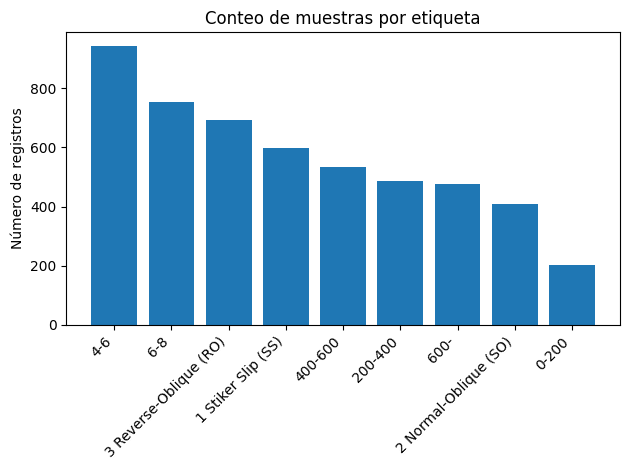

In [194]:
import matplotlib.pyplot as plt

# Preparar datos
etiquetas = counts.index
cantidades = counts.values

# Plot
fig, ax = plt.subplots()
ax.bar(etiquetas, cantidades)
ax.set_xticks(range(len(etiquetas)))
ax.set_xticklabels(etiquetas, rotation=45, ha='right')
ax.set_ylabel('Número de registros')
ax.set_title('Conteo de muestras por etiqueta')
fig.tight_layout()
plt.show()

In [195]:
import itertools

# Define todas las etiquetas posibles en cada categoría
falla_all = ['1 Stiker Slip (SS)', '2 Normal-Oblique (SO)', '3 Reverse-Oblique (RO)']
mag_all   = ['4-6', '6-8']
vs_all    = ['0-200', '200-400', '400-600', '600-']

# Detecta cuáles de esas columnas están realmente en tu df_final
falla = [c for c in falla_all if c in df_final.columns]
mag   = [c for c in mag_all   if c in df_final.columns]
vs    = [c for c in vs_all    if c in df_final.columns]

# Para cada fila, extrae la etiqueta activa en cada grupo
df_final['Falla_lbl'] = df_final[falla].idxmax(axis=1)
df_final['Mag_lbl']   = df_final[mag].idxmax(axis=1)
df_final['Vs_lbl']    = df_final[vs].idxmax(axis=1)

# Construye la combinación y cuenta
df_final['Combo'] = df_final['Falla_lbl'] + ' | ' + df_final['Mag_lbl'] + ' | ' + df_final['Vs_lbl']
counts = df_final['Combo'].value_counts()

# Imprime cuántas de las 24 posibles hay
present = counts.index.tolist()
num_present = len(present)
num_total   = len(falla_all) * len(mag_all) * len(vs_all)
print(f"Combinaciones presentes: {num_present} / {num_total}")

# Opcional: muestra las que faltan
all_combos = {' | '.join(p) for p in itertools.product(falla_all, mag_all, vs_all)}
missing = sorted(all_combos - set(present))
print("\nCombinaciones que NO aparecen:")
for m in missing:
    print("  -", m)

# Y si quieres ver un desglose:
print("\nConteo por combinación:")
print(counts.to_frame('Count'))

Combinaciones presentes: 24 / 24

Combinaciones que NO aparecen:

Conteo por combinación:
                                        Count
Combo                                        
1 Stiker Slip (SS) | 6-8 | 400-600        101
2 Normal-Oblique (SO) | 4-6 | 200-400     101
3 Reverse-Oblique (RO) | 4-6 | 600-       100
3 Reverse-Oblique (RO) | 6-8 | 600-        99
2 Normal-Oblique (SO) | 4-6 | 600-         99
1 Stiker Slip (SS) | 4-6 | 400-600         98
3 Reverse-Oblique (RO) | 4-6 | 200-400     98
1 Stiker Slip (SS) | 4-6 | 200-400         97
3 Reverse-Oblique (RO) | 6-8 | 200-400     96
3 Reverse-Oblique (RO) | 6-8 | 400-600     95
2 Normal-Oblique (SO) | 4-6 | 400-600      91
3 Reverse-Oblique (RO) | 4-6 | 400-600     88
1 Stiker Slip (SS) | 4-6 | 600-            88
3 Reverse-Oblique (RO) | 6-8 | 0-200       81
1 Stiker Slip (SS) | 6-8 | 600-            76
2 Normal-Oblique (SO) | 6-8 | 400-600      60
1 Stiker Slip (SS) | 6-8 | 200-400         60
1 Stiker Slip (SS) | 4-6 | 0-200    

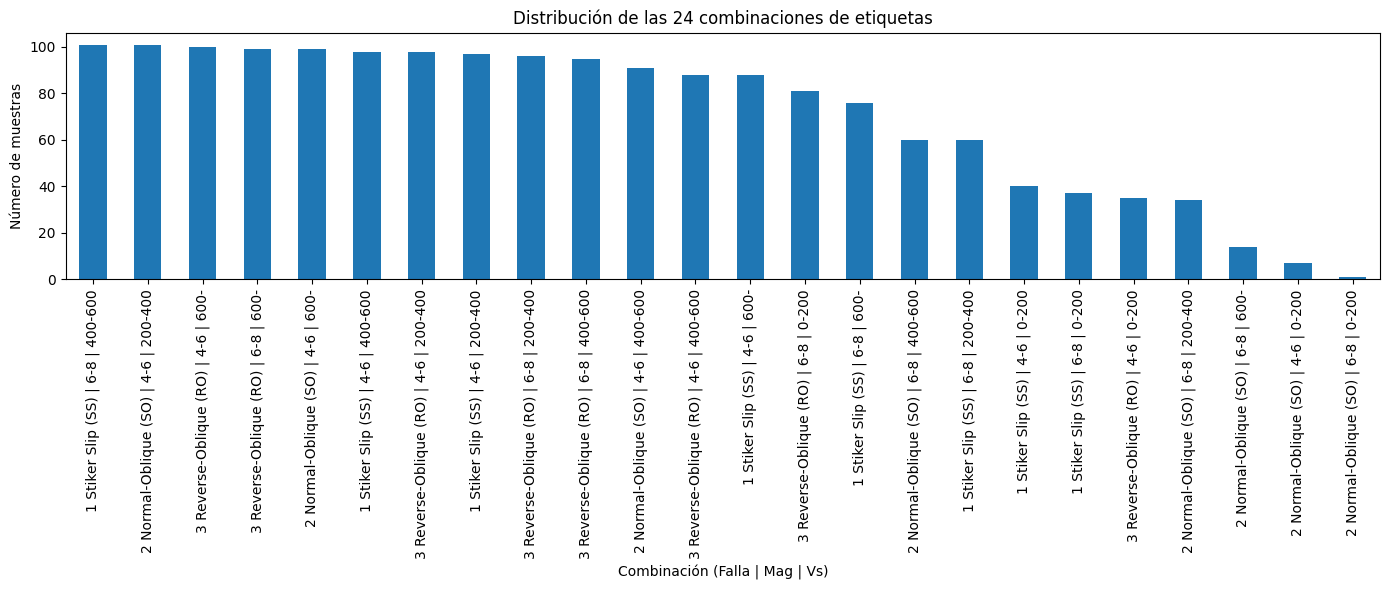

In [196]:

plt.figure(figsize=(14, 6))
counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Combinación (Falla | Mag | Vs)')
plt.ylabel('Número de muestras')
plt.title('Distribución de las 24 combinaciones de etiquetas')
plt.tight_layout()
plt.show()

In [197]:
threshold = 15

#    Identificar combinaciones a eliminar
to_eliminate = counts[counts < threshold].index.tolist()
print(f"\nCombinaciones con menos de {threshold} muestras (se eliminarán):")
for combo in to_eliminate:
    print("  -", combo, ":", counts[combo], "muestras")

#    Filtrar el DataFrame
n_before = len(df_final)
df_final = df_final[~df_final['Combo'].isin(to_eliminate)].reset_index(drop=True)
n_after  = len(df_final)

print(f"\nFilas antes de filtrar: {n_before}")
print(f"Filas después de filtrar: {n_after}")
print(f"Muestras eliminadas: {n_before - n_after}")
print(f"Combinaciones restantes: {df_final['Combo'].nunique()}")


Combinaciones con menos de 15 muestras (se eliminarán):
  - 2 Normal-Oblique (SO) | 6-8 | 600- : 14 muestras
  - 2 Normal-Oblique (SO) | 4-6 | 0-200 : 7 muestras
  - 2 Normal-Oblique (SO) | 6-8 | 0-200 : 1 muestras

Filas antes de filtrar: 1696
Filas después de filtrar: 1674
Muestras eliminadas: 22
Combinaciones restantes: 21


In [198]:
# Drop df_final['Falla_lbl'] = df_final[falla].idxmax(axis=1)
#df_final['Mag_lbl']   = df_final[mag].idxmax(axis=1)
#df_final['Vs_lbl']    = df_final[vs].idxmax(axis=1)

df_final = df_final.drop(columns=['Falla_lbl', 'Mag_lbl', 'Vs_lbl'])
df_final = df_final.drop(columns=['Combo'])
df_final = df_final.drop(columns=['Archivo'])

In [199]:

# Guardar dataset final
os.makedirs('data/processed', exist_ok=True)
df_final.to_json('data/processed/dataset_final.json', index=False)
print('Final dataset saved to data/processed/dataset_final.json')


Final dataset saved to data/processed/dataset_final.json
